In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import subprocess
import os

In [2]:
# import my modules for reading dataframes from folder /modules

import sys

sys.path.insert(0, 'modules/')

from segments_data_processor import SegmentsDataProcessor, SegmentsDataProcessor2
from gap_data_processor import GapDataProcessor
from lengths_data_processor import process_lengths_data


In [3]:
sdp = SegmentsDataProcessor('datasets/P6.Inform/I062.015.WGS.Tumor_events.txt')

test_data = sdp.get_cnv_segments()

test_data

,Chromosome,Copy Number,Length,Start,End
0,1,3,648442,0,648442
1,1,3,4657565,158568553,163226118
2,1,3,29721681,219528940,249250621
3,2,3,21620422,10768725,32389147
4,2,4,79537,33069397,33148934
...,...,...,...,...,...
276,X,4,2364990,148940532,151305522
277,X,3,1976171,151305522,153281693
278,X,4,663577,153281693,153945270
279,X,3,777322,153945270,154722592


In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281 entries, 0 to 280
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Chromosome   281 non-null    object
 1   Copy Number  281 non-null    int64 
 2   Length       281 non-null    int64 
 3   Start        281 non-null    int64 
 4   End          281 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 11.1+ KB


In [5]:
lengths = pd.read_csv('datasets/hs37d5.fa.fai', sep='\t', header=None)

In [6]:
lengths = process_lengths_data(lengths)

# data is in good format
lengths

,Length
Chromosome,
1,249250621
2,243199373
3,198022430
4,191154276
5,180915260
6,171115067
7,159138663
8,146364022
9,141213431


In [7]:
gdp = GapDataProcessor('datasets/gap.txt')

centromeres = gdp.get_centromeres()

centromeres

,Chromosome,Start,End
0,1,121535434,124535434
1,2,92326171,95326171
2,3,90504854,93504854
3,4,49660117,52660117
4,5,46405641,49405641
5,6,58830166,61830166
6,7,58054331,61054331
7,8,43838887,46838887
8,9,47367679,50367679
9,X,58632012,61632012


### Initializing VCF parser

In [8]:
import vcf

vcf_reader_raw = vcf.Reader(filename='datasets/P6.Inform/P13.WES.raw.vcf.gz')
vcf_reader = vcf.Reader(filename='datasets/P6.Inform/P13.WES.Discovery.vcf.gz')

In [9]:
# i = 0
# for record in vcf_reader_raw:
#     if i == 1:
#         break
#     i+=1
#     print(record.genotype("I062.033.T").data.GT)

### Fill profile by segments with copy number 2

Some constants and parameters:

In [10]:
Mb = 1000000
S_small = 3 * Mb
qual_threshold = 200

In [11]:
# TODO refactoring - count length in this function
def insert_row(df, _chr, cn, length, start, end, index):
    normal_segment = pd.DataFrame({
        'Chromosome': [ _chr ],
        'Copy Number': [ cn ],
        'Length': [length],
        'Start': [ start ],
        'End': [ end ]
    })
                
    return pd.concat([df.iloc[:index], normal_segment, df.iloc[index:]]).reset_index(drop=True)


def fill_segments(data, sex='female'):
    df = data.copy()
    index_df = 0

    for index, row in data.iterrows():
        # determining normal CN based on sex and chromosome
        normal_cn = 2
        if sex == 'male' and row['Chromosome'] == 'X':
            normal_cn = 1
        
        # first cnv region in chromosome
        if index == 0 or data.loc[index-1, 'Chromosome'] != data.loc[index, 'Chromosome']:
            if row['Start'] != 0:
                df = insert_row(df, row['Chromosome'], normal_cn, row['Start'], 0, row['Start'], index_df)
                index_df += 1

        # not first cnv region in chromosome 
        elif data.loc[index-1, 'End'] != data.loc[index, 'Start']:
            prev = data.loc[index-1]

            df = insert_row(df, row['Chromosome'], normal_cn, row['Start'] - prev['End'], prev['End'], row['Start'], index_df)
            index_df += 1

        # last cnv region in chromosome
        if index == len(data) - 1 or data.loc[index+1, 'Chromosome'] != data.loc[index, 'Chromosome']:

            chr_len = lengths.loc[row['Chromosome'], 'Length']
            if row['End'] != chr_len:      
                df = insert_row(df, row['Chromosome'], normal_cn, chr_len - row['End'], row['End'], chr_len, index_df+1)
                index_df += 1

        index_df += 1
        
    return df

In [12]:
pd.set_option('display.max_rows', 1000)

In [13]:
filled_data = fill_segments(test_data)

filled_data

,Chromosome,Copy Number,Length,Start,End
0,1,3,648442,0,648442
1,1,2,157920111,648442,158568553
2,1,3,4657565,158568553,163226118
3,1,2,56302822,163226118,219528940
4,1,3,29721681,219528940,249250621
5,2,2,10768725,0,10768725
6,2,3,21620422,10768725,32389147
7,2,2,680250,32389147,33069397
8,2,4,79537,33069397,33148934
9,2,3,1388890,33148934,34537824


In [14]:
chromosome_names = [str(_chr) for _chr in range(1, 23)]
chromosome_names.append('X')

In [15]:
# TODO refactoring - get dataframe made by segments of current chromosome and then work with it
def remove_centromeres(data):
    for _chr in chromosome_names:
        centromere_start = centromeres.loc[centromeres['Chromosome'] == _chr, 'Start'].iloc[0]
        centromere_end = centromeres.loc[centromeres['Chromosome'] == _chr, 'End'].iloc[0]
        
        # drop segments that start and end in centromere  
        data = data.drop(data[(data['Chromosome'] == _chr) & (data['Start'] >= centromere_start) & (data['End'] <= centromere_end)].index)
        
        # cut segment that overlaps centromere  
        row_df = data.loc[(data['Chromosome'] == _chr) & (data['Start'] < centromere_start) & (data['End'] > centromere_end)]
        if not row_df.empty:
            row = row_df.iloc[0]
            data.loc[row.name, 'End'] = centromere_start
            data.loc[row.name, 'Length'] = centromere_start - row['Start']        
            data = insert_row(data, _chr, row['Copy Number'], row['End'] - centromere_end, centromere_end, row['End'], row.name + 1)
        
        # cut segment that ends in centromere  
        data.loc[(data['Chromosome'] == _chr) & (data['End'] >= centromere_start) & (data['End'] <= centromere_end), 'End'] = centromere_start

        # cut segment that starts in centromere  
        data.loc[(data['Chromosome'] == _chr) & (data['Start'] >= centromere_start) & (data['Start'] <= centromere_end), 'Start'] = centromere_end
    
    return data

In [16]:
data_without_centromeres = remove_centromeres(filled_data)

data_without_centromeres

,Chromosome,Copy Number,Length,Start,End
0,1,3,648442,0,648442
1,1,2,120886992,648442,121535434
2,1,2,34033119,124535434,158568553
3,1,3,4657565,158568553,163226118
4,1,2,56302822,163226118,219528940
5,1,3,29721681,219528940,249250621
6,2,2,10768725,0,10768725
7,2,3,21620422,10768725,32389147
8,2,2,680250,32389147,33069397
9,2,4,79537,33069397,33148934


In [17]:
def name_chr_arms(data):
    data['Arm'] = 'p'
    for _chr in chromosome_names:
        centromere_end = centromeres.loc[centromeres['Chromosome'] == _chr, 'End'].iloc[0]

        data.loc[(data['Chromosome'] == _chr) & (data['Start'] >= centromere_end), 'Arm'] = 'q'
        
    return data

In [18]:
data_with_named_arms = name_chr_arms(data_without_centromeres)

data_with_named_arms

,Chromosome,Copy Number,Length,Start,End,Arm
0,1,3,648442,0,648442,p
1,1,2,120886992,648442,121535434,p
2,1,2,34033119,124535434,158568553,q
3,1,3,4657565,158568553,163226118,q
4,1,2,56302822,163226118,219528940,q
5,1,3,29721681,219528940,249250621,q
6,2,2,10768725,0,10768725,p
7,2,3,21620422,10768725,32389147,p
8,2,2,680250,32389147,33069397,p
9,2,4,79537,33069397,33148934,p


### Counting DNA index

In [19]:
def count_dna_index(data, sex='female'):
    cns = list(data['Copy Number'])
    weights = list(data['Length'])

    for _chr in chromosome_names:
        chr_segments = data[data['Chromosome'] == _chr]
        if chr_segments.empty:
            normal_cn = 2
            if sex == 'male' and _chr == 'X':
                normal_cn = 1
            
            centromere_start = centromeres.loc[centromeres['Chromosome'] == _chr, 'Start'].iloc[0]
            centromere_end = centromeres.loc[centromeres['Chromosome'] == _chr, 'End'].iloc[0]
            chromosome_end = lengths.loc[_chr, 'Length']

            cns.extend([normal_cn, normal_cn])
            weights.extend([centromere_start, chromosome_end - centromere_end])

    cn_avg = np.average(cns, weights=weights)
    dna_index = cn_avg / 2

    return dna_index

In [20]:
dna_index = count_dna_index(data_with_named_arms)

dna_index

1.0678149680785216

### Estimating number of chromosomes

Estimating number of chromosomes by taking one segment adjacent with centromere for each chromosome arm. If segment is longer than 1.5 Mb then copy number of that segment is added to the sum, else average copy number of arm is added.

In [21]:
pericentric_seg_treshold = 1.5 * Mb

def count_arm_avg_cn(arm_data):
    cns = list(arm_data['Copy Number'])
    weights = list(arm_data['Length'])
    
    return np.average(cns, weights=weights)


# estimate chromosome number for p arm
def estimate_p_arm(chr_segments):
    p_arm_data = chr_segments.loc[chr_segments['Arm'] == 'p']
    last_segment_p = p_arm_data.iloc[-1]
    if last_segment_p['Length'] >= pericentric_seg_treshold:
        return last_segment_p['Copy Number']
    else:
        return count_arm_avg_cn(p_arm_data)
    
    
# estimate chromosome number for q arm    
def estimate_q_arm(chr_segments):
    q_arm_data = chr_segments.loc[chr_segments['Arm'] == 'q']
    first_segment_q = q_arm_data.iloc[0]
    if first_segment_q['Length'] >= pericentric_seg_treshold:
        return first_segment_q['Copy Number']
    else:
        return count_arm_avg_cn(q_arm_data)


def estimate_chromosome_number(data, sex='female'):
    chromosome_number = 0

    for _chr in chromosome_names:
        chr_segments = data[data['Chromosome'] == _chr]
        
        # if there are no CNVs in whole chromosome add 2 for p and q arm to sum
        if chr_segments.empty:
            normal_cn = 2
            if sex == 'male' and _chr == 'X':
                normal_cn = 1
            
            chromosome_number += normal_cn + normal_cn
            continue

        chromosome_number += estimate_p_arm(chr_segments)
        chromosome_number += estimate_q_arm(chr_segments)        
                    
    return chromosome_number

In [22]:
chromosome_number = estimate_chromosome_number(data_with_named_arms)

chromosome_number

96.91965493840645

### Counting number of variants for each segment

Quality check that filters out records their characteristics don't meet requirements. If characteristics are not present, record remains.

In [25]:
def has_quality(record):
    info = record.INFO
    return record.QUAL > qual_threshold and ('QD' not in info.keys() or info['QD'] > 10.0) and ('MQ' not in info.keys() or info['MQ'] > 40.0) \
        and ('FS' not in info.keys() or info['FS'] < 30.0 ) and ('SOR' not in info.keys() or info['SOR'] < 3.0) \
        and ('MQRankSum' not in info.keys() or info['MQRankSum'] > -12.5) and ('ReadPosRankSum' not in info.keys() or info['ReadPosRankSum'] > -8.0)

In [26]:
def count_variants(data, vcf_reader, sample):
    filled_variants_data = data.copy()
    filled_variants_data['Variants Count per Mb'] = 0

    for index, row in filled_variants_data.iterrows():
        
        segment_records = None
        try:
            segment_records = vcf_reader.fetch(row['Chromosome'], row['Start'], row['End'])
        except ValueError:
            continue
        
        count = 0
        for record in segment_records:
            sample_data = record.genotype(sample).data

            if has_quality(record) and sample_data.GT != './.' and sample_data.GT != '0/0' and sample_data.AD != None and sample_data.AD[1] != 0:
                count += 1

        length_mb = filled_variants_data.loc[index, 'Length'] / 1000000
        filled_variants_data.loc[index, 'Variants Count per Mb'] = count / length_mb

    return filled_variants_data

In [27]:
filled_variants_data = count_variants(data_with_named_arms, vcf_reader_raw, 'I062_015.T')

filled_variants_data

,Chromosome,Copy Number,Length,Start,End,Arm,Variants Count per Mb
0,1,3,648442,0,648442,p,0.000000
1,1,2,120886992,648442,121535434,p,8.263916
2,1,2,34033119,124535434,158568553,q,6.963805
3,1,3,4657565,158568553,163226118,q,17.820471
4,1,2,56302822,163226118,219528940,q,6.536084
5,1,3,29721681,219528940,249250621,q,9.824478
6,2,2,10768725,0,10768725,p,2.878707
7,2,3,21620422,10768725,32389147,p,6.475359
8,2,2,680250,32389147,33069397,p,11.760382
9,2,4,79537,33069397,33148934,p,0.000000


### Some visualizations

In [28]:
def plot_chromosomes_variant_count(data):
    fig,axs = plt.subplots(nrows=12, ncols=2, figsize=(15, 40), constrained_layout=True)
    max_count = data['Variants Count per Mb'].max()

    for index, name in enumerate(chromosome_names):
        chr_data = data[data['Chromosome'] == name]
        chr_data = chr_data.reset_index(drop=True)

        ax = axs[index // 2, index % 2]
        ax.set_ylim([0, max_count + 10])
        ax.set_title('Variant counts - chromosome ' + name, fontdict={'fontsize': 16})
        ax.bar(chr_data.index, chr_data['Variants Count per Mb'])

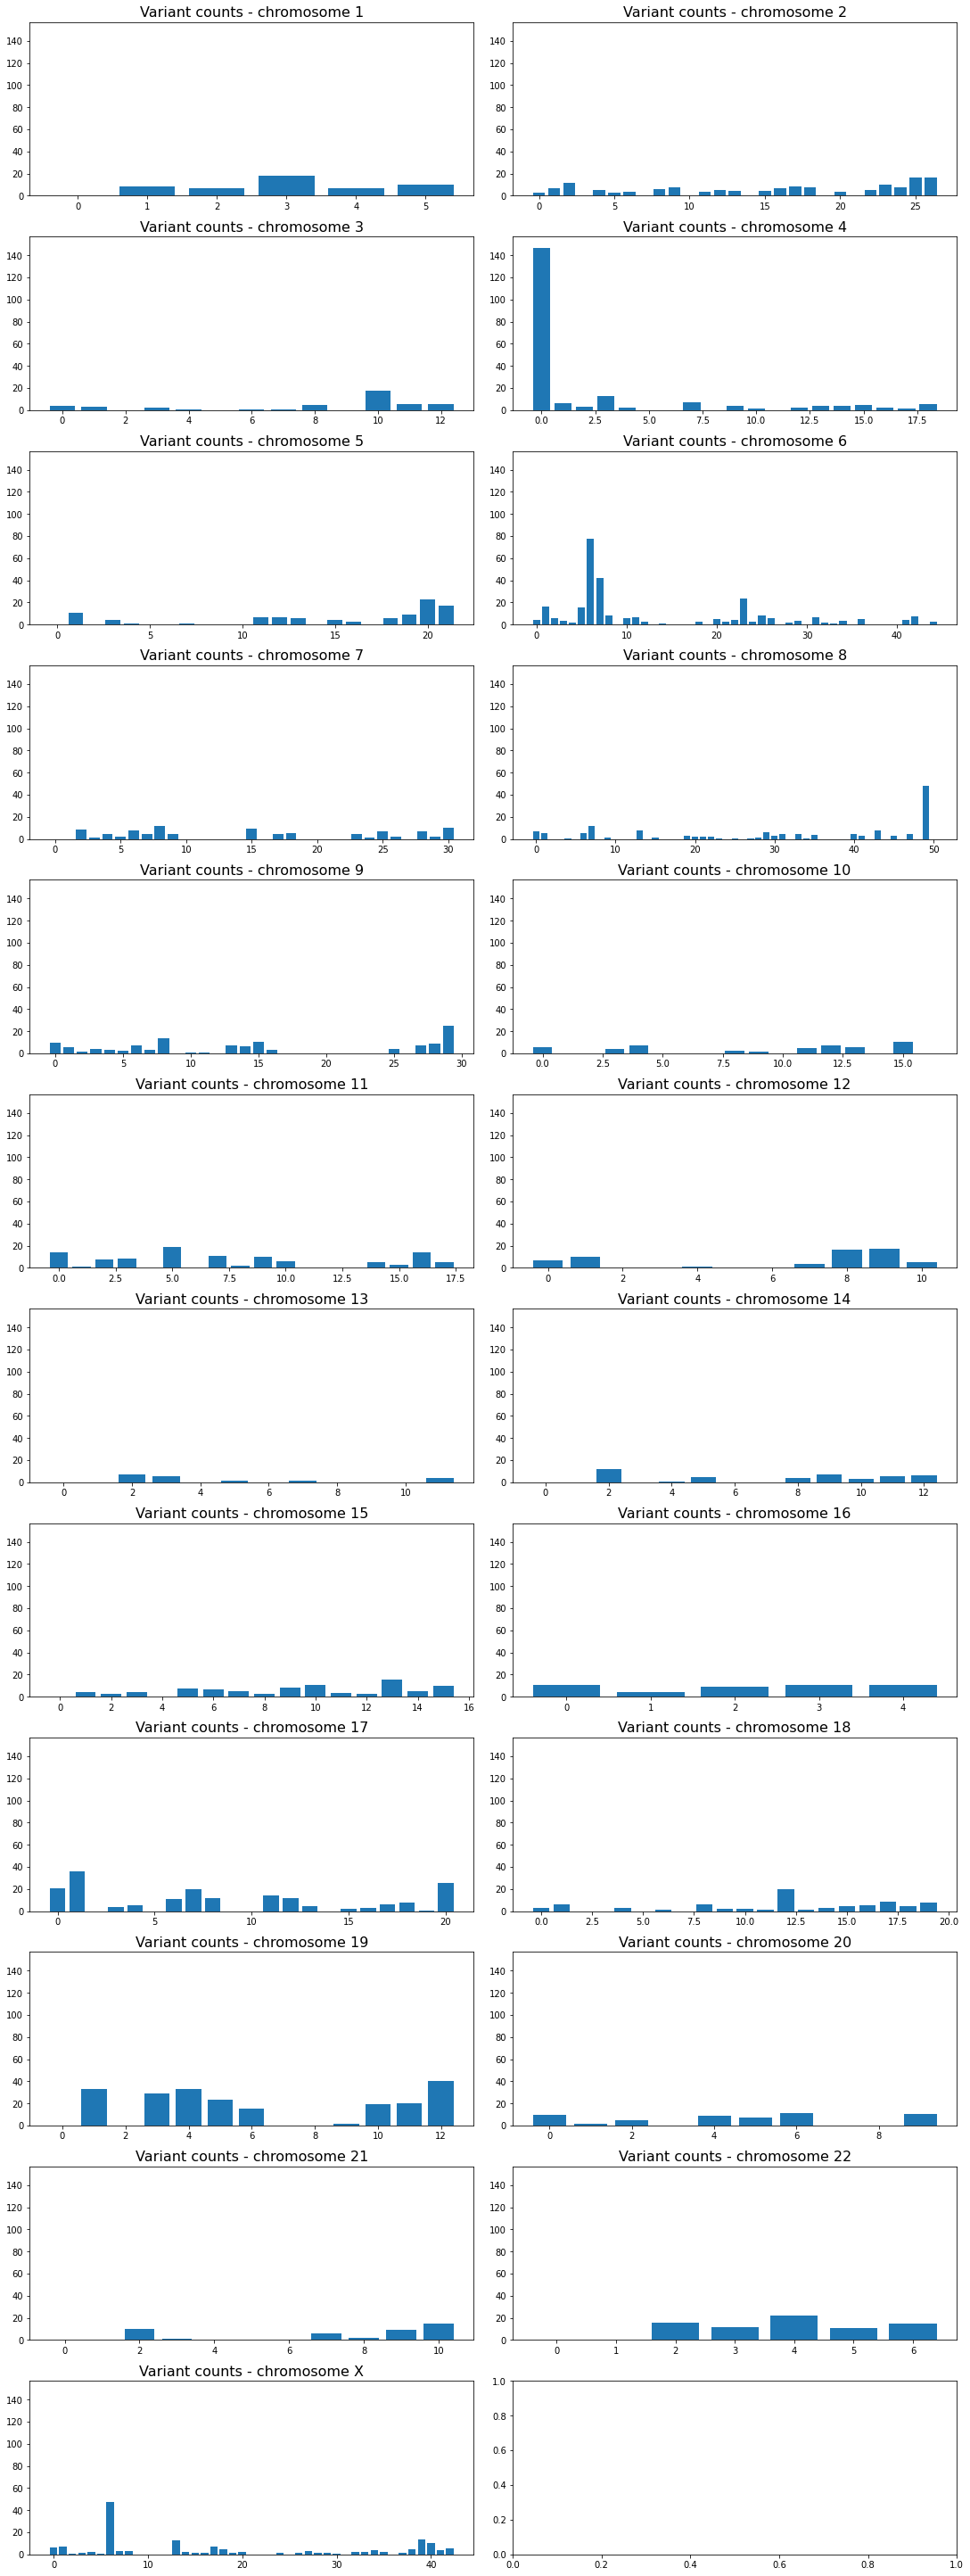

In [29]:
plot_chromosomes_variant_count(filled_variants_data)

In [30]:
def plot_genome_variant_counts(data):
    max_count = data['Variants Count per Mb'].max()
    yticks = [i for i in range(0, int(max_count) + 10, 5)]

    plt.figure(figsize=(20, 10))
    plt.yticks(ticks=yticks)
    plt.title('Variant counts', fontdict={'fontsize': 16})
    plt.bar(data.index, data['Variants Count per Mb'])

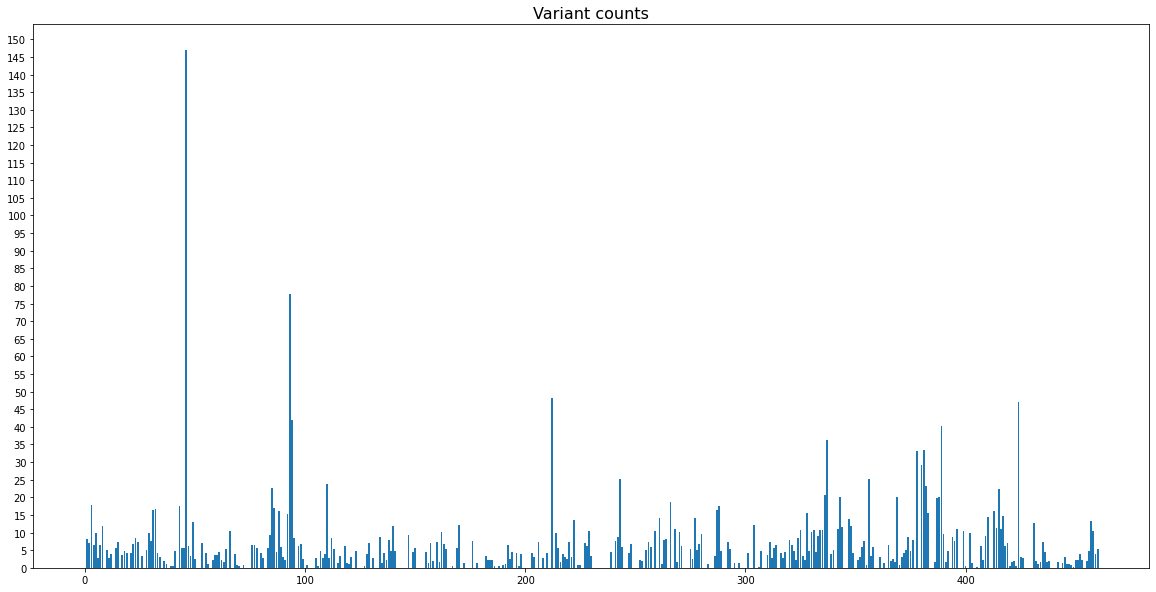

In [31]:
plot_genome_variant_counts(filled_variants_data)

### Segments sorted by number of variants

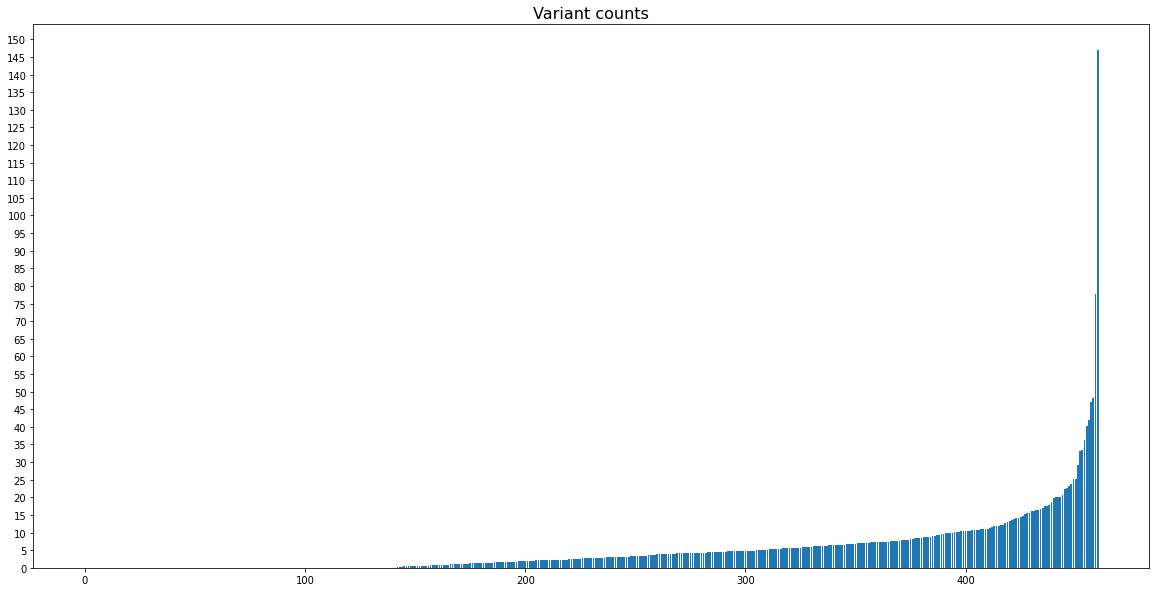

In [32]:
sorted_filled_variants_data = filled_variants_data.sort_values(by=['Variants Count per Mb']).reset_index()

plot_genome_variant_counts(sorted_filled_variants_data)

In [33]:
def plot_histogram(data):
    max_value = data['Variants Count per Mb'].max()
    xticks = [i for i in range(0, int(max_value) + 10, 4)]
    plt.figure(figsize=(20,10))
    plt.hist(data['Variants Count per Mb'], bins=int(data['Variants Count per Mb'].max()) // 2)
    plt.title('Histogram of variants count values', fontdict={'fontsize': 16})
    plt.xticks(ticks=xticks)

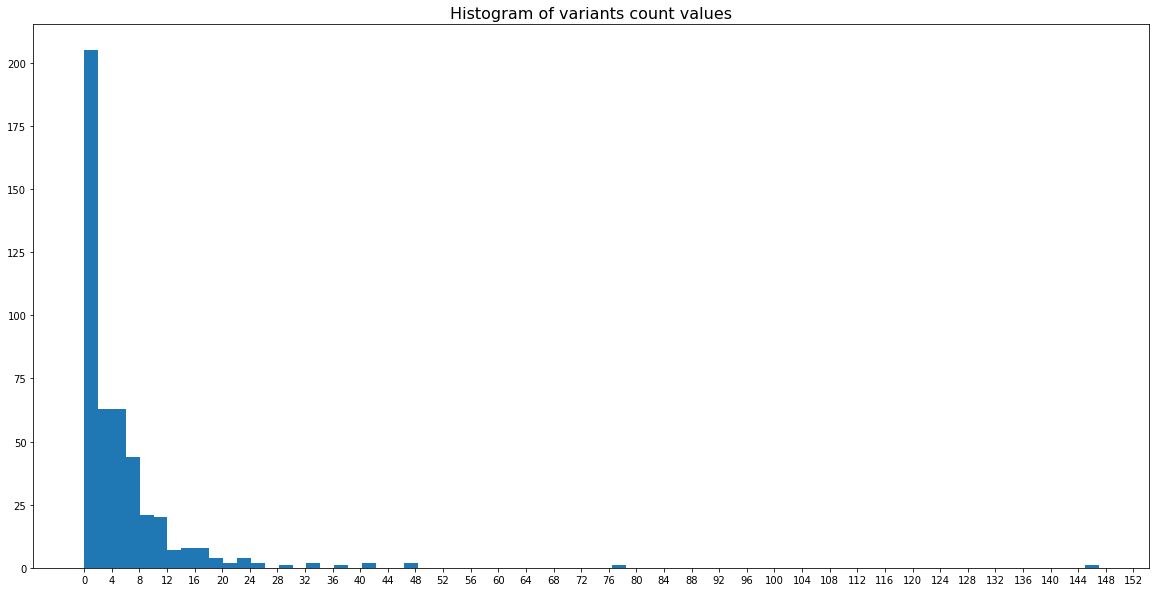

In [34]:
plot_histogram(filled_variants_data)

### Counting allele frequencies for each segment

In [35]:
def count_allele_freqs(data, vcf_reader, sample):
    data_with_af = data.copy()
    data_with_af['Allele Frequencies'] = [list() for x in range(len(data_with_af.index))]

    for index, row in data_with_af.iterrows():

        segment_records = None
        try:
            segment_records = vcf_reader.fetch(row['Chromosome'], row['Start'], row['End'])
        except ValueError:
            continue
            
        allele_freqs = []
        for record in segment_records:
            sample_data = record.genotype(sample).data

            if has_quality(record) and sample_data.GT != './.' and sample_data.GT != '0/0' and sample_data.AD != './.' and sample_data.AD != None \
                and sample_data.AD[1] != 0:
               
                allele_freq = sample_data.AD[1] / (sample_data.AD[0] + sample_data.AD[1])
                allele_freqs.append(allele_freq)

        data_with_af.at[index, 'Allele Frequencies'] = allele_freqs
        
    return data_with_af

In [36]:
data_with_af = count_allele_freqs(data_with_named_arms, vcf_reader_raw, 'I062_015.T')

data_with_af

,Chromosome,Copy Number,Length,Start,End,Arm,Allele Frequencies
0,1,3,648442,0,648442,p,[]
1,1,2,120886992,648442,121535434,p,"[1.0, 0.5490196078431373, 1.0, 1.0, 1.0, 1.0, ..."
2,1,2,34033119,124535434,158568553,q,"[0.5902777777777778, 0.4097222222222222, 0.443..."
3,1,3,4657565,158568553,163226118,q,"[0.5503597122302158, 0.5813953488372093, 0.416..."
4,1,2,56302822,163226118,219528940,q,"[0.5845070422535211, 0.35691318327974275, 0.74..."
5,1,3,29721681,219528940,249250621,q,"[0.41509433962264153, 0.997289972899729, 1.0, ..."
6,2,2,10768725,0,10768725,p,"[0.8709677419354839, 1.0, 1.0, 1.0, 1.0, 0.836..."
7,2,3,21620422,10768725,32389147,p,"[0.355, 0.43828715365239296, 0.376744186046511..."
8,2,2,680250,32389147,33069397,p,"[1.0, 0.9948979591836735, 0.996969696969697, 1..."
9,2,4,79537,33069397,33148934,p,[]


### Coercing and counting of LSTs based on copy numbers and allelic frequencies

In [37]:
# insert new segment that was created by linking 
def insert_row_with_af(df, _chr, cn, length, start, end, allele_freqs, arm, index):
    normal_segment = pd.DataFrame({
        'Chromosome': [ _chr ],
        'Copy Number': [ cn ],
        'Length': [length],
        'Start': [ start ],
        'End': [ end ],
        'Allele Frequencies': [allele_freqs],
        'Arm': [arm]
    })
                
    return pd.concat([df.iloc[:index], normal_segment, df.iloc[index:]]).reset_index(drop=True)


# linking adjacent segments of small filtered out segment 
def link_segments(df, prev, _next, small):
    df = df.drop(index=prev.name)
    df = df.drop(index=_next.name)
    
    new_allele_freqs = []
    new_allele_freqs.extend(prev['Allele Frequencies'])
    new_allele_freqs.extend(_next['Allele Frequencies'])
    new_allele_freqs.extend(small['Allele Frequencies'])
    
    df = insert_row_with_af(df, prev['Chromosome'], prev['Copy Number'],  _next['End'] - prev['Start'],  prev['Start'], _next['End'], new_allele_freqs, \
                            prev['Arm'], prev.name)
    
    return df


# statistical tests for equality of allelic frequencies for two segments
def have_equal_allele_freqs(segment1, segment2):
    alpha = 0.05
    min_n = 3
    
    allele_freqs1 = segment1['Allele Frequencies']
    allele_freqs2 = segment2['Allele Frequencies']
    
    # check if there is sufficient number of observations, if no, segments are compared only by copy number
    if len(allele_freqs1) < min_n and len(allele_freqs2) < min_n:
        return True
    
    if len(allele_freqs1) < min_n or len(allele_freqs2) < min_n:
        return False
    
    statistic, p_value = stats.ttest_ind(allele_freqs1, allele_freqs2, equal_var=False)
    
    if p_value > alpha:
        return True
    
    return False


# coercing function
def coercing(data):
    df = data.copy()

    while True:

        # get smallest segment
        row = df[df['Length'] == df['Length'].min()].iloc[0]
        index = row.name

        # filter out?
        if row['Length'] < S_small:

            # not first or last segment of profile?
            if index != 0 and index != len(df) - 1:
                prev = df.loc[ index-1 ]
                _next = df.loc[ index+1 ]

                # can link?
                if prev['Chromosome'] == _next['Chromosome'] and prev['Arm'] == _next['Arm'] and prev['Copy Number'] == _next['Copy Number'] \
                    and have_equal_allele_freqs(prev, _next):
                    
                    df = link_segments(df, prev, _next, row)

            # delete small segment
            df = df.drop(index=index).reset_index(drop=True)

        # if there are no small segments left -> end
        else:
            return df

In [38]:
coerced_data_with_af = coercing(data_with_af)

coerced_data_with_af

,Chromosome,Copy Number,Length,Start,End,Arm,Allele Frequencies
0,1,2,120886992,648442,121535434,p,"[1.0, 0.5490196078431373, 1.0, 1.0, 1.0, 1.0, ..."
1,1,2,34033119,124535434,158568553,q,"[0.5902777777777778, 0.4097222222222222, 0.443..."
2,1,3,4657565,158568553,163226118,q,"[0.5503597122302158, 0.5813953488372093, 0.416..."
3,1,2,56302822,163226118,219528940,q,"[0.5845070422535211, 0.35691318327974275, 0.74..."
4,1,3,29721681,219528940,249250621,q,"[0.41509433962264153, 0.997289972899729, 1.0, ..."
5,2,2,10768725,0,10768725,p,"[0.8709677419354839, 1.0, 1.0, 1.0, 1.0, 0.836..."
6,2,3,23769099,10768725,34537824,p,"[0.355, 0.43828715365239296, 0.376744186046511..."
7,2,2,57788347,34537824,92326171,p,"[0.48, 1.0, 0.44715447154471544, 0.43373493975..."
8,2,2,61545390,97539595,159084985,q,"[0.49333333333333335, 0.5526315789473685, 1.0,..."
9,2,2,38640088,159560769,198200857,q,"[1.0, 0.4357976653696498, 0.46226415094339623,..."


Counting number of LSTs.

In [39]:
def count_lsts(data, LST_SMb=10*Mb):
    
    lsts = 0
    for index, row in data.iterrows():

        # not last segment in profile?
        if index != len(data) - 1:

            _next = data.loc[index+1]
            if row['Length'] >= LST_SMb and _next['Length'] >= LST_SMb and _next['Chromosome'] == row['Chromosome'] and _next['Arm'] == row['Arm'] \
                and _next['Start'] - row['End'] < S_small:
                
                lsts += 1

    return lsts

In [40]:
lsts_with_af = count_lsts(coerced_data_with_af)

lsts_with_af

30

### LST

In [41]:
Mb = 1000000
S_small = 3 * Mb
LST_SMbs = [x for x in range(3, 12)]
qual_threshold = 200
pericentric_seg_treshold = 1.5 * Mb

chromosome_names = [str(_chr) for _chr in range(1, 23)]
chromosome_names.append('X')
chromosome_names.append('Y')

def lst(data, vcf_reader, sample):
    data = fill_segments(data)
    data = remove_centromeres(data)
    data = name_chr_arms(data)
    dna_index = count_dna_index(data)
    chromosome_number = estimate_chromosome_number(data)
    data = count_allele_freqs(data, vcf_reader, sample)
    data = coercing(data)
    lsts = {}
    for LST_SMb in LST_SMbs:
        lsts[str(LST_SMb)+' Mb'] = count_lsts(data, LST_SMb*Mb)
    
    return lsts, dna_index, chromosome_number

In [42]:
lsts, dna_index, chromosome_number = lst(test_data, vcf_reader_raw, 'I062_015.T')

lsts, dna_index, chromosome_number

({'3 Mb': 80,
  '4 Mb': 64,
  '5 Mb': 51,
  '6 Mb': 45,
  '7 Mb': 42,
  '8 Mb': 36,
  '9 Mb': 32,
  '10 Mb': 30,
  '11 Mb': 27},
 1.0665518762261803,
 96.91965493840645)

In [43]:
dirpath = 'datasets/P6.Inform'

samples = [
    {
        'Filename': 'I062.007.WGS.Pre_events.txt',
        'Sample name': 'I062_007.C'
    },
    {
        'Filename': 'I062.007.WGS.Tumor_events.txt',
        'Sample name': 'I062_022.T'
    },
    {
        'Filename': 'I062.015.WGS.Tumor_events.txt',
        'Sample name': 'I062_015.T'
    },
    {
        'Filename': 'I062.022.WGS.Tumor_events.txt',
        'Sample name': 'I062_022.T'
    },
    {
        'Filename': 'I062.033.WGS.Tumor_events.txt',
        'Sample name': 'I062.033.T'
    }
]

In [44]:
for i in range(len(samples)):
    sample = samples[i]
    relative_path = dirpath + '/' + sample['Filename']
    
    sdp = None
    if i == len(samples) - 1:
        sdp = SegmentsDataProcessor2(relative_path, 'P6.Rec7')
        
    else:
        sdp = SegmentsDataProcessor(relative_path)
        
    data = sdp.get_cnv_segments()
    
    sample['LST'], sample['DNA Index'], sample['Chromosome Number'] = lst(data, vcf_reader_raw, sample['Sample name'])

In [45]:
results_data = pd.DataFrame(samples)
results_data = pd.concat([results_data, results_data['LST'].apply(pd.Series)], axis=1)
results_data.drop(columns=['Sample name', 'LST'], inplace=True)

results_data

,Filename,DNA Index,Chromosome Number,3 Mb,4 Mb,5 Mb,6 Mb,7 Mb,8 Mb,9 Mb,10 Mb,11 Mb
0,I062.007.WGS.Pre_events.txt,0.986870,96.919655,24,19,19,19,15,13,11,11,11
1,I062.007.WGS.Tumor_events.txt,1.035317,96.919655,30,24,21,21,21,19,15,15,13
2,I062.015.WGS.Tumor_events.txt,1.066552,96.919655,80,64,51,45,42,36,32,30,27
3,I062.022.WGS.Tumor_events.txt,1.045798,96.919655,105,76,59,53,45,37,28,25,19
4,I062.033.WGS.Tumor_events.txt,1.046807,96.919655,101,74,55,47,39,32,29,27,23
